<a href="https://colab.research.google.com/github/hasin-abrar/Machine-Learning/blob/master/LSTM_TargetChanged_PoemGeneratorSeq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string

import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import re
import glob
import os
import pickle
!pip install bcolz
import bcolz
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline
# plt.switch_backend('agg')
import matplotlib.ticker as ticker

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
main_directory = '/content/drive/My Drive/Colab Notebooks/PyTorch Practice/Data/'
glove_path = main_directory+"EncodingVector/"

     |████████████████████████████████| 1.5MB 5.5MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2668660 sha256=f8ba3c9e57c8c0d4da5bf53ed43f9c1bd6d80e7b5fdc4c5805f40616d406792e
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
cuda


In [ ]:
SOS_token = 0
EOS_token = 1

class Words:
  def __init__(self):
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "SOS", 1: "EOS"}
    self.n_words = 2  # Count SOS and EOS

  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)

  def addWord(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1

In [ ]:
def unicodeToAscii(s):
  return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
  )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
  s = unicodeToAscii(s.lower().strip())
  s = re.sub(r"([.!?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  return s

In [ ]:
MAX_LENGTH = 15
def filterLine(line):
  return len(line.split(' ')) < MAX_LENGTH

def filterLines(lines):
  return [line for line in lines if filterLine(line)]

def indexesFromSentence(words, sentence):
  return [words.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(words, sentence):
  indexes = indexesFromSentence(words, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def GetInputWordsTensors():
  df = pd.read_csv(main_directory+"PoemDataset/kaggle_poem_dataset.csv")
  william_poems = df[df["Author"] == "William Shakespeare"]
  # print(william_poems.iloc[33, 4].split('\n')[:4])
  df = william_poems
  poems = "\n".join(df.iloc[:, 4].values)
  lines = [normalizeString(p) for p in poems.split('\n')]
  lines = filterLines(lines)
  input_tensors = []
  target_tensors = []
  input_words = Words()
  input_words.addSentence(lines[0])
  input_tensors.append(tensorFromSentence(input_words, lines[0]))
  for i in range(1,len(lines)-1):
    input_words.addSentence(lines[i])
    input_tensors.append(tensorFromSentence(input_words, lines[i]))
    target_tensors.append(tensorFromSentence(input_words, lines[i]))
  input_words.addSentence(lines[len(lines)-1])
  target_tensors.append(tensorFromSentence(input_words, lines[len(lines)-1]))
  print('Word Count: %d'%(input_words.n_words))
  return input_words, input_tensors, target_tensors


In [ ]:
input_words, input_tensors, target_tensors = GetInputWordsTensors()
print(len(input_tensors))
print(len(target_tensors))
# print(input_words.word2count)

let the bird of loudest lay
Word Count: 4116


In [ ]:
words = []
idx = 0
word2idx = {}

glove_path = main_directory+"EncodingVector/"
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.50.dat', mode='w')

with open(f'{glove_path}/glove.6B.50d.txt', 'rb') as f:
  for l in f:
    line = l.decode().split()
    word = line[0]
    words.append(word)
    word2idx[word] = idx
    idx += 1
    vect = np.array(line[1:]).astype(np.float)
    vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400001, 50)), rootdir=f'{glove_path}/6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'{glove_path}/6B.50_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}/6B.50_idx.pkl', 'wb'))

In [ ]:
vectors = bcolz.open(f'{glove_path}/6B.50.dat')[:]
words = pickle.load(open(f'{glove_path}/6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}/6B.50_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [ ]:
words = []
idx = 0
word2idx = {}

glove_path = main_directory+"EncodingVector/"
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.200.dat', mode='w')

with open(f'{glove_path}/glove.6B.200d.txt', 'rb') as f:
  for l in f:
    line = l.decode().split()
    word = line[0]
    words.append(word)
    word2idx[word] = idx
    idx += 1
    vect = np.array(line[1:]).astype(np.float)
    vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400001, 200)), rootdir=f'{glove_path}/6B.200.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'{glove_path}/6B.200_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}/6B.200_idx.pkl', 'wb'))

In [ ]:
vectors = bcolz.open(f'{glove_path}/6B.200.dat')[:]
words = pickle.load(open(f'{glove_path}/6B.200_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}/6B.200_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [ ]:
glove['the'][0]

-0.071549

In [ ]:
target_vocab = [input_words.index2word[i] for i in range(input_words.n_words)]
print(len(target_vocab))

4116


In [ ]:
matrix_len = len(target_vocab)
emb_dim = 200
weights_matrix = np.zeros((matrix_len, emb_dim))

words_found = 0

for i, word in enumerate(target_vocab):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.zeros((emb_dim, ))
weights_matrix = torch.from_numpy(weights_matrix).to(device)
print(words_found)        

3821


In [ ]:

def CreateEmbLayer(weights_matrix, non_trainable=False):
  num_embeddings, embedding_dim = weights_matrix.size()
  emb_layer = nn.Embedding(num_embeddings, embedding_dim)
  emb_layer.load_state_dict({'weight': weights_matrix})
  if non_trainable:
    emb_layer.weight.requires_grad = False
  return emb_layer, embedding_dim

class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size, weights_matrix, nlayers=2):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = nlayers

    self.embedding, self.embedding_dim = CreateEmbLayer(weights_matrix, non_trainable=False)
    self.LSTM = nn.LSTM(self.embedding_dim, self.hidden_size,num_layers=self.num_layers)

  def forward(self, input, hidden, cell):
    embedded = self.embedding(input).view(1, 1, -1)
    output = embedded
    # print(hidden.size())
    output, (hidden,cell) = self.LSTM(output, (hidden,cell))
    return output, hidden, cell

  def initHidden(self):
    return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)
  
  def initCellState(self):
    return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, weights_matrix,nlayers=2):
    super(DecoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = nlayers

    self.embedding, self.embedding_dim = CreateEmbLayer(weights_matrix, non_trainable=False)
    self.LSTM = nn.LSTM(self.embedding_dim, self.hidden_size,num_layers=self.num_layers)
    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input, hidden, cell):
    output = self.embedding(input).view(1, 1, -1)
    output = F.relu(output)
    output, (hidden, cell) = self.LSTM(output, (hidden,cell))
    output = self.softmax(self.out(output[0]))
    return output, hidden, cell

  def initHidden(self):
    return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)
  
  def initCellState(self):
    return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [ ]:
teacher_forcing_ratio = 0


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
  encoder_hidden = encoder.initHidden()
  encoder_cell = encoder.initCellState()

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_tensor.size(0)
  target_length = target_tensor.size(0)

  # encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

  loss = 0

  for ei in range(input_length):
    encoder_output, encoder_hidden, encoder_cell = encoder(
        input_tensor[ei], encoder_hidden, encoder_cell)
    # encoder_outputs[ei] = encoder_output[0, 0]

  decoder_input = torch.tensor([[SOS_token]], device=device)

  decoder_hidden = encoder_hidden
  decoder_cell = encoder_cell

  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

  if use_teacher_forcing:
      # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
      decoder_output, decoder_hidden, decoder_cell = decoder(
        decoder_input, decoder_hidden, decoder_cell)
      loss += criterion(decoder_output, target_tensor[di])
      decoder_input = target_tensor[di]  # Teacher forcing

  else:
      # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
      decoder_output, decoder_hidden, decoder_cell = decoder(
        decoder_input, decoder_hidden, decoder_cell)
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.squeeze().detach()  # detach from history as input

      loss += criterion(decoder_output, target_tensor[di])
      if decoder_input.item() == EOS_token:
        break

  loss.backward()

  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)


def timeSince(since, percent):
  now = time.time()
  s = now - since
  es = s / (percent)
  rs = es - s
  return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
  plt.figure()
  fig, ax = plt.subplots()
  # this locator puts ticks at regular intervals
  loc = ticker.MultipleLocator(base=0.2)
  ax.yaxis.set_major_locator(loc)
  plt.plot(points)

In [ ]:
from datetime import datetime
def trainIters(encoder, decoder, n_iters, model_name, print_every=5, plot_every=5, save_every=5, learning_rate=0.01):
  start = time.time()
  plot_losses = []
  print_loss_total = 0  # Reset every print_every
  plot_loss_total = 0  # Reset every plot_every
  current_avg_loss = 100

  encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
  
  criterion = nn.CrossEntropyLoss()

  for iter in range(1, n_iters + 1):
    for i in range(len(input_tensors)):
      input_tensor = input_tensors[i]
      target_tensor = target_tensors[i]

      loss = train(input_tensor, target_tensor, encoder,
                decoder, encoder_optimizer, decoder_optimizer, criterion)
      print_loss_total += loss
      plot_loss_total += loss

    if iter % print_every == 0:
      print_loss_avg = print_loss_total / (print_every*len(input_tensors))
      
      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print('Current Time: %s ~ %s (%d %d%%) AVG: %.4f Total: %0.4f' % (current_time, timeSince(start, iter / n_iters),
                                iter, iter / n_iters * 100, print_loss_avg, print_loss_total))
      if print_loss_avg < current_avg_loss:
        torch.save(encoder.state_dict(), main_directory+'SavedPoemModels/enc_best_'+model_name)
        torch.save(decoder.state_dict(), main_directory+'SavedPoemModels/dec_best_'+model_name)
        current_avg_loss = print_loss_avg
      print_loss_total = 0

    if iter % plot_every == 0:
      plot_loss_avg = plot_loss_total / (plot_every*len(input_tensors))
      plot_losses.append(plot_loss_avg)
      plot_loss_total = 0
    
    if iter % save_every == 0:
      torch.save(encoder.state_dict(), main_directory+'SavedPoemModels/enc_'+model_name)
      torch.save(decoder.state_dict(), main_directory+'SavedPoemModels/dec_'+model_name)
      
    

  showPlot(plot_losses)

Started Training at : 08:43:52
Current Time: 08:47:36 ~ 3m 43s (- 145m 33s) (5 2%) AVG: 6.8319 Total: 107841.2808
Current Time: 08:51:24 ~ 7m 31s (- 143m 2s) (10 5%) AVG: 7.3035 Total: 115285.8800
Current Time: 08:55:22 ~ 11m 30s (- 141m 51s) (15 7%) AVG: 7.8901 Total: 124544.9902
Current Time: 08:59:22 ~ 15m 30s (- 139m 32s) (20 10%) AVG: 7.8864 Total: 124487.2924
Current Time: 09:02:47 ~ 18m 55s (- 132m 25s) (25 12%) AVG: 6.0996 Total: 96282.8933
Current Time: 09:06:14 ~ 22m 21s (- 126m 43s) (30 15%) AVG: 6.4847 Total: 102360.8448
Current Time: 09:09:38 ~ 25m 46s (- 121m 30s) (35 17%) AVG: 6.3759 Total: 100644.0487
Current Time: 09:13:00 ~ 29m 8s (- 116m 33s) (40 20%) AVG: 6.2862 Total: 99228.1963
Current Time: 09:16:10 ~ 32m 18s (- 111m 15s) (45 22%) AVG: 5.6230 Total: 88759.7399
Current Time: 09:19:28 ~ 35m 36s (- 106m 49s) (50 25%) AVG: 6.0810 Total: 95988.8599
Current Time: 09:22:44 ~ 38m 52s (- 102m 28s) (55 27%) AVG: 5.9089 Total: 93271.5416
Current Time: 09:25:58 ~ 42m 6s (- 9

<Figure size 432x288 with 0 Axes>

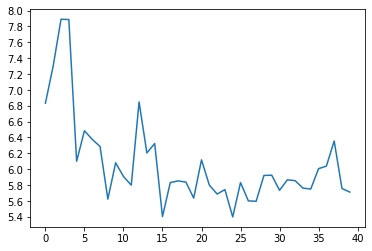

In [ ]:
hidden_size = 200

encoder = EncoderRNN(input_words.n_words, hidden_size, weights_matrix).to(device)
decoder = DecoderRNN(hidden_size, input_words.n_words, weights_matrix).to(device)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
model_name= 'h200_ep_200.pt'
print('Started Training at : %s'%(current_time))
trainIters(encoder, decoder, 200,model_name, print_every=5, plot_every=5)

In [ ]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
import time

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print('Current time: %s'%(current_time) )

Current time: 07:54:17


In [ ]:
def GetFileChar():
  file = open(main_directory+'break.txt')
  lines = file.readlines()
  return lines[0].strip()

q = GetFileChar()
if q == 'c':
  print('as')
else:
  print(q)

as


In [ ]:
def GetEncodedVector(encoder, sentence):
  with torch.no_grad():
    sentence_tensor = tensorFromSentence(input_words, sentence)
    encoder_hidden = encoder.initHidden()
    encoder_cell = encoder.initCellState()
    input_length = sentence_tensor.size(0)

    for ei in range(input_length):
      encoder_output, encoder_hidden, encoder_cell = encoder(
          sentence_tensor[ei], encoder_hidden, encoder_cell)
  return encoder_hidden, encoder_cell

In [ ]:
def evaluate(decoder, context_hid, context_cell, max_length=MAX_LENGTH):
  with torch.no_grad():
    decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

    decoder_hidden = context_hid
    decoder_cell = context_cell

    decoded_words = []
    # decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
      decoder_output, decoder_hidden, decoder_cell = decoder(
          decoder_input, decoder_hidden, decoder_cell)
      topv, topi = decoder_output.data.topk(1)
      if topi.item() == EOS_token or topi.item() == SOS_token:
        # decoded_words.append('EOS')
        break
      else:
        decoded_words.append(input_words.index2word[topi.item()])

      decoder_input = topi.squeeze().detach()

    return decoded_words

In [ ]:
from scipy import spatial

def GetContext(encoder, sentences, query_word):
  qw_hidden,qw_cell = GetEncodedVector(encoder, query_word)
  if sentences == []:
    return qw_hidden, qw_cell
  qw_hidden = qw_hidden.cpu().numpy()
  qw_cell = qw_cell.cpu().numpy()
  sen_hiddens = []
  sen_cells = []
  for sentence in sentences:
    sen_hid, sen_cell = GetEncodedVector(encoder, sentence)
    sen_hiddens.append(sen_hid.cpu().numpy() )
    sen_cells.append(sen_cell.cpu().numpy() )
  sen_hiddens = np.array(sen_hiddens)
  sen_cells = np.array(sen_cells)
  weights_hid = []
  weights_cell = []
  for sen_hidden in sen_hiddens:
    # print(type())
    dist = spatial.distance.cosine(sen_hidden, qw_hidden)
    weights_hid.append(np.array([dist]))
  for sen_cell in sen_cells:
    dist = spatial.distance.cosine(sen_cell, qw_cell)
    weights_cell.append(np.array([dist]))

  weights_hid = np.array(weights_hid/max(weights_hid)).reshape(-1,1,1,1)
  weights_cell = np.array(weights_cell/max(weights_cell)).reshape(-1,1,1,1)
  # print(sen_hiddens.shape)
  context_hid = np.average(weights_hid * sen_hiddens, axis = 0)
  context_cell = np.average(weights_cell * sen_cells, axis = 0)
  # print(weights.shape)
  # print(context.shape)
  context_hid = torch.from_numpy(context_hid).to(device)
  context_cell = torch.from_numpy(context_cell).to(device)
  # print(context.size())
  return context_hid, context_cell

def GetContext_P(sequences, query_word):
  qw_embed = weights_matrix[input_words.word2index[query_word]].cpu().numpy()
  if sequences == []:
    return qw_embed
  seq_embeddings = []
  for sequence in sequences:
    seq_embed = np.zeros((1, emb_dim))
    sequence = sequence.split(' ')
    for word in sequence:
      seq_embed += weights_matrix[input_words.word2index[word]].cpu().numpy()
    seq_embeddings.append(seq_embed)
  seq_embeddings = np.array(seq_embeddings)
  
  weights = []
  for seq_embed in seq_embeddings:
      # get the distance between the query word and the sentence embeddings
      print(seq_embed.shape)
      print(qw_embed.shape)
      dist = spatial.distance.cosine(seq_embed, qw_embed)
      weights.append(np.array([dist]))
      
  # normalize the distances
  weights = np.array(weights/max(weights))
      
  # get the final weighted context
  context = sum(weights * seq_embeddings)
  context = torch.from_numpy(context).to(device)
  print(type(context))
  return context



In [ ]:
def GeneratePoem(encoder, decoder, query_word, nLines=10):
  output_sentences = []
  for i in range(nLines):
      context_hid, context_cell = GetContext(encoder, output_sentences[-5:], query_word)
      # context = torch.from_numpy(context).to(device)
      # print(type(context))
      output_words = evaluate(decoder, context_hid, context_cell)
      output_sentence = ' '.join(output_words)
      output_sentences.append(output_sentence)
      print(output_sentence)

hidden_size = 200

encoder = EncoderRNN(input_words.n_words, hidden_size, weights_matrix).to(device)
decoder = DecoderRNN(hidden_size, input_words.n_words, weights_matrix).to(device)
model_name= 'h200_ep_200.pt'

encoder.load_state_dict(torch.load(main_directory+'SavedPoemModels/enc_'+model_name))
decoder.load_state_dict(torch.load(main_directory+'SavedPoemModels/dec_'+model_name))

GeneratePoem(encoder, decoder, 'limb')      

NameError: ignored

In [ ]:
sequences = ['sky', 'sky love']
query_word = 'love'
context = GetContext(encoder, sequences, query_word)
print(type(context))
print(context.size())

<class 'torch.Tensor'>
torch.Size([1, 1, 200])


In [ ]:
w = np.array([[1],[2]])
w = np.array(w/max(w))
w = np.reshape(w,(-1,1,1,1))
print(w.shape)
print(w)
q = np.ones((2,1,1,3))
print(q)
print(w.shape)
result = np.multiply(w,q)
print(result.shape)
print(result)
result = np.average(w*q,axis = 0)
print("\nResult:")
# print(result)
print(result.shape)

NameError: ignored

In [ ]:
s = [1,2,3,4,5,6,7]
print(s[-5:])

[]


In [ ]:
start_sentence = "From fairest creatures we"
GeneratePoem(encoder, decoder, normalizeString(start_sentence))

from fairest creatures we
we fear we rich we ever fear breast breast breast
pluck fed fed whereupon pluck or fed ?
to makes makes to breach to makes .
to wail to to to to to .
to mingle to to to to to .
to mingle to to to to to .
to mingle to to to to to .
to mingle to to to to to .
to mingle to to to to to .
to mingle to to to to to .


In [ ]:
def get_context(sequences, query_word):
  """
    This function takes as input multiple lines generated by the model so far and a query_word or the theme of the poem.
    
    So, the approach is we will add the embeddings of all the words in a sentence to get the sentence embeddings and will
    create the sentence embeddings for all the sentences created so far.
    
    Now, to summarize all the sentence embeddings into a single vector, we will calculate the distance of all the sentence
    from the query_word. These weights are normalized and will be used as the weights to combine the sentence embeddings.
    
    This final embedding vector or the context will be passed to the Decoder as a hidden state and a new line is generated from it.
  """
  
  assert query_word in sg_obj.word2idx
  
  # null vector containing all zeroes
  query_word_embed = sg_obj.word2vec.get(query_word, np.zeros(shape=(EMBEDDING_DIM)))
  
  if sequences == []:
      return query_word_embed
  
  # to keep all the sentence embeddings
  seq_embeddings = []
  for seq in sequences:  
    # add up all the word embeddings of a sequence
    zero_vector = np.zeros(shape=(EMBEDDING_DIM))
    for word in seq:
        zero_vector += sg_obj.word2vec.get(word, np.zeros(shape=(EMBEDDING_DIM)))
    seq_embeddings.append(zero_vector)
  seq_embeddings = np.array(seq_embeddings)
          
  weights = []
  for seq_embed in seq_embeddings:
      # get the distance between the query word and the sentence embeddings
      dist = spatial.distance.cosine(seq_embed, query_word_embed)
      weights.append(np.array([dist]))
      
  # normalize the distances
  weights = np.array(weights/max(weights))
      
  # get the final weighted context
  context = sum(weights * seq_embeddings)
  
  return context

def get_sample_line(context):
  """
      Get a single line using the provided context as a hidden state
      
      Parameters:
          context (np.array): generated context of the same size as the word_embedding
  """
  
  # sentence start token
  sos_token = np.array([[sg_obj.word2idx.get("<sos>")]])
  
  # create the empty lstm state vectors
  h = np.array([context])    
  c = np.zeros(shape=(1, LATENT_DIM))
  
  # so we know when to quit
  eos_token = sg_obj.word2idx['<eos>']
  
  output_sequence = []
  
  # limit the length of the generated line
  for i in range(sg_obj.MAX_SEQ_LEN):
      
      # predict the first word
      # the outputed stated are passed to the lstm to generate the next word in the sequence
      o, h, c = Decoder.predict([sos_token, h, c])
      
      # get the probabilities generated from the dense layer
      probs = o[0,0]
      
      if np.argmax(probs) ==0:
          print("Something went wrong!!")
      
      probs = np.nan_to_num(probs)
      # the word-indices starts from 1 so 1st value does not count
      probs[0] = 0 
      
      # normalize the probabilities
      probs /= probs.sum()
      
      # select a random word with provided probability of being selected
      selected_idx = np.random.choice(len(probs), p=probs)
      
      # if the generated word is equal to eos_token, terminate
      if selected_idx == eos_token:
          break
      
      # append the generated word to the output_sequence
      output_sequence.append(sg_obj.idx2word.get(selected_idx, "Error <%d>" % selected_idx))
      
      # the word generated will be used as an input to generated the new word
      sos_token[0][0] = selected_idx
  
  # return the sequence
  return output_sequence    

################### MAIN ################
# the theme of the poem - only single word (for simplicity)
query_word = "love"

# to append the generated poem lines
poem_lines = []

# first sequence containing only ones, this will be used to generate the context
sequences = []

# we will be generating 8 lines, you can play around with this
for line_no in range(8):
    
    # get the context, for the first line the context will contain the embeddings of the theme words itself
    context = get_context(sequences, query_word)
    
    try:
        # generate a new line and append it
        sequences.append(get_sample_line(context))
    except:
        pass
    
    poem_lines.append(" ".join(sequences[-1]))
    
print("\n\n")
print("\n".join(poem_lines))
